In [6]:
#Pytorch
import torch
from torchvision import datasets, transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset

#For data preprocessing
import numpy as np
import pandas as pd
import os
#For plotting
import matplotlib.pyplot as plt



myseed = 42069  # set a random seed for reproducibility
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [7]:
torch.cuda.is_available()

False

# Data Loading

In [2]:
data_path = "./data/"
train_path = os.path.join(data_path, "training_data.csv")
test_path = os.path.join(data_path, "testing_data.csv")

In [3]:
def load_data(train_path, test_path):
    data_train = pd.read_csv(train_path)
    data_test = pd.read_csv(test_path)
    return data_train, data_test

In [4]:
data_train, data_test = load_data(train_path, test_path)

In [5]:
print(data_train.shape)
print(data_test.shape)
print(len(data_train.columns))
print(data_train.columns)

(8784, 11)
(8760, 10)
11
Index(['AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'PM10', 'PM2.5',
       'RH', 'SO2'],
      dtype='object')


In [11]:
data_train.describe()

,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,PM10,PM2.5,RH,SO2
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,25.256894,1.804080,0.360590,0.169854,2.715811,12.276252,14.991823,52.838892,38.625345,76.184676,2.829558
std,5.437083,0.169114,0.173651,0.160766,4.094463,7.410589,9.864936,29.673641,26.654979,10.321507,1.415210
min,6.600000,1.500000,0.010000,-0.030000,-0.500000,-0.400000,-0.400000,1.000000,2.700000,21.000000,-0.500000
25%,22.000000,1.700000,0.240000,0.070000,0.800000,6.695000,8.000000,31.000000,18.300000,69.000000,1.800000
50%,26.000000,1.800000,0.340000,0.130000,1.500000,11.000000,13.000000,46.000000,31.300000,78.000000,2.600000
75%,29.000000,1.900000,0.460000,0.220000,2.900000,17.000000,20.000000,68.000000,52.100000,84.000000,3.500000
max,36.000000,2.700000,2.370000,2.410000,91.000000,58.000000,113.000000,238.000000,186.000000,98.000000,14.000000


# EDA

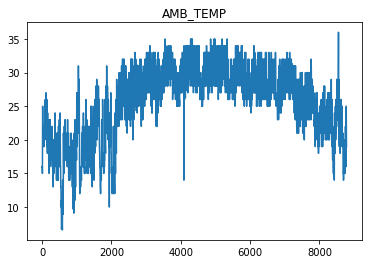

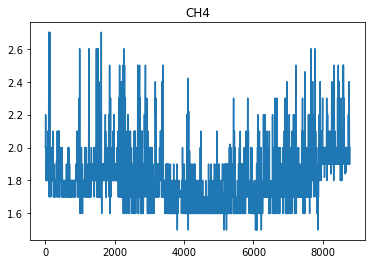

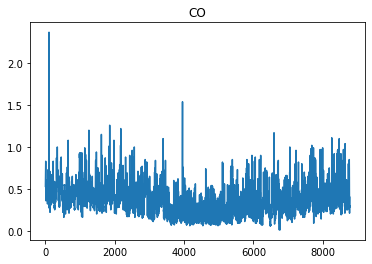

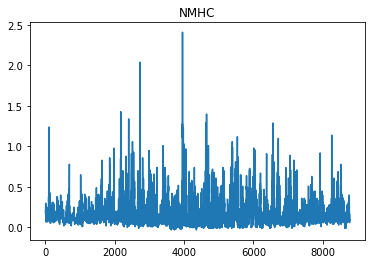

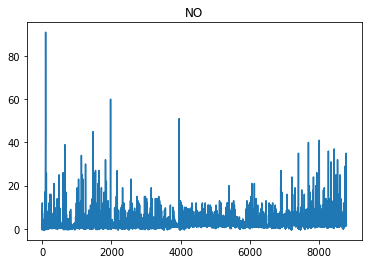

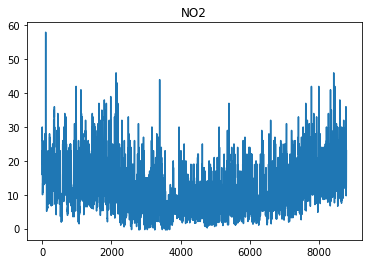

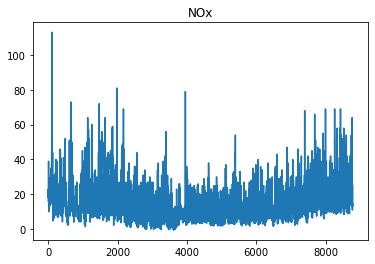

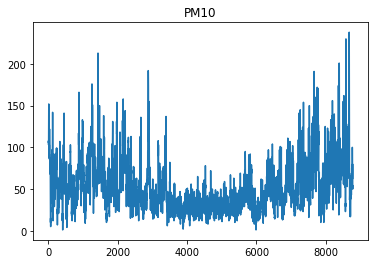

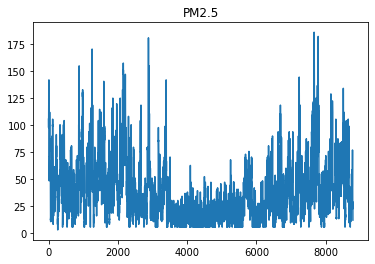

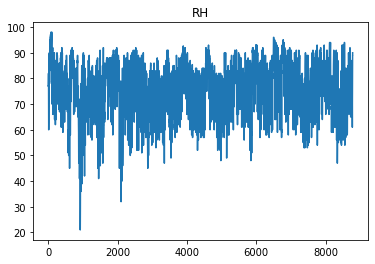

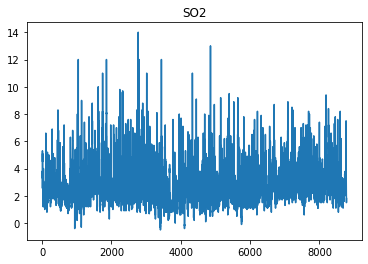

In [14]:
for col in data_train.columns:
    plt.plot(data_train[col])
    plt.title(col)
    plt.show()

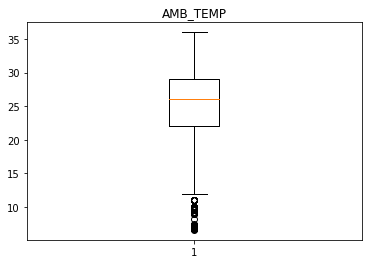

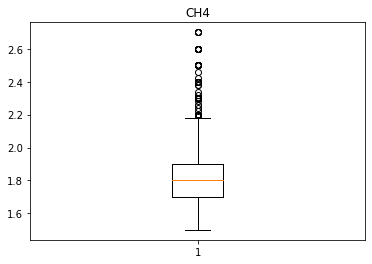

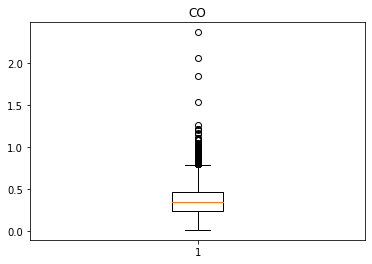

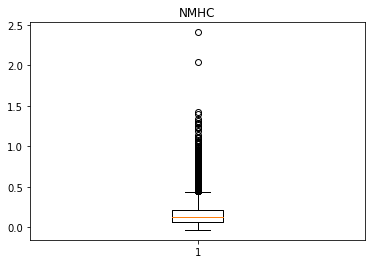

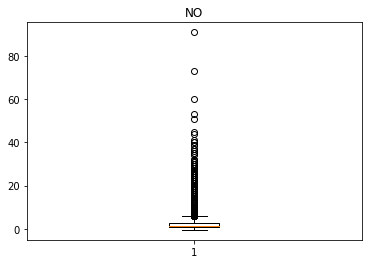

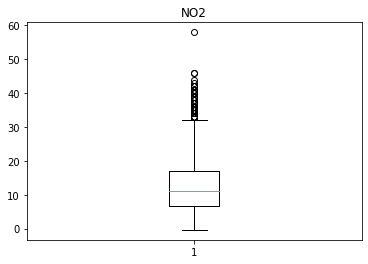

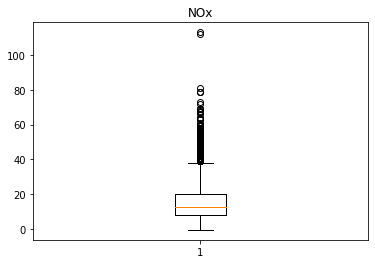

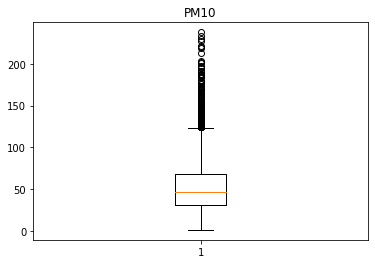

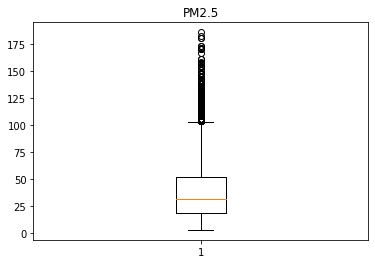

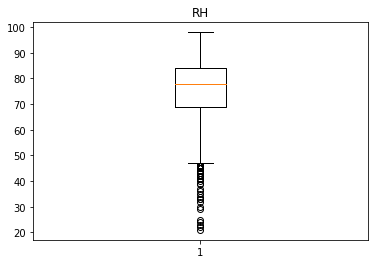

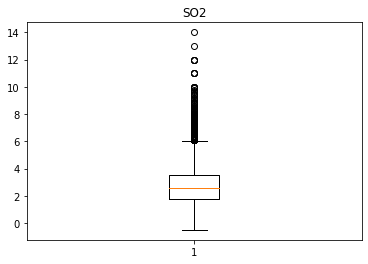

In [15]:
for col in data_train.columns:
    plt.boxplot(data_train[col])
    plt.title(col)
    plt.show()

# Data Preprocessing

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)